In [3]:
import pandas as pd
data = pd.read_csv('D2.data', sep=',',names=['sepal length', 'sepal width', 'petal length', 'petal width', 'class'])
data



,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [4]:
# 去除缺失值的行
data = data.dropna()
#去除重复值
data.drop_duplicates(inplace=True)
#恢复索引
data.index = range(data.shape[0])
# 查看数据缺失值情况
data.isnull().sum()

sepal length    0
sepal width     0
petal length    0
petal width     0
class           0
dtype: int64

In [5]:
# 对类别标签进行labelencoder处理
from sklearn.preprocessing import StandardScaler, LabelEncoder
le= LabelEncoder()
data['class'] = le.fit_transform(data['class'])
data



,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
142,6.7,3.0,5.2,2.3,2
143,6.3,2.5,5.0,1.9,2
144,6.5,3.0,5.2,2.0,2
145,6.2,3.4,5.4,2.3,2


In [6]:
# 实现BP神经网络算法
import numpy as np
import time
class BP(object):
    """
    layer 为神经网络各层神经元的个数,包括输出层神经元个数,传参形式以列表传入；
    activate:为各层的激活函数，传参形式为字符串或列表，
             若传入一个字符串，则各层激活函数相同，
             若传入一个列表，则列表元素代表各层激活函数
             可传参数有：（1）sigmoid：S型函数
                         （2）tanh：双曲正弦函数
                         （3）relu:max(0,x)函数
                         （4）purline：线性函数
                         （5）softsign：平滑函数
    lr:学习率，默认为0.01
    epoch：最大迭代次数 默认为1e4
    该模型具有的主要方法和属性如下：
    fit(X,Y):模型拟合方法
    predict(X):输出预测方法
    predict_label(X):分类标签输出预测方法
    activate:激活函数列表
    W：权值列表
    
    """
    def __init__(self,layer,**kargs):
        self.layer = np.array(layer).reshape(1,-1)
        if 'activate' in kargs.keys():
            if str(type(kargs["activate"])) == "<class 'str'>":    
                self.activate = [kargs["activate"]]*int(len(layer))
            else:
                self.activate = kargs["activate"]
        else:
            self.activate = ["sigmoid"]*int(len(layer))
        self.diff_activate = []
        if 'lr' in kargs.keys():
            self.lr = kargs["lr"]
        else:
            self.lr = 0.01
        if 'epoch' in kargs.keys():
            self.epoch = kargs["epoch"]
        else:
            self.epoch = int(1e4)
            
        self.X = None
        self.Y = None
        self.W = None
        self.output = []
        self.delta = []
        self.sum_input = []
        
        
    # 1、选择激活函数
    def activation_func(self):
        temp_func = []
        for i in range(len(self.activate)):
            if self.activate[i] == "sigmoid":
                temp_func.append(lambda x:1/(1+np.exp(-x)))
                self.diff_activate.append(lambda x:(1/(1+np.exp(-x)))*(1-(1/(1+np.exp(-x)))))
            if self.activate[i] == "tanh":
                temp_func.append(lambda x:(np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x)))
                self.diff_activate.append(lambda x:((-np.exp(x) + np.exp(-x))*(np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))**2 + 1))
            if self.activate[i] == "softsign":
                temp_func.append(lambda x:x/(1+np.abs(x)))
                self.diff_activate.append(lambda x:1/((1+x/np.abs(x)*x)**2))
            if self.activate[i] == "relu":
                temp_func.append(lambda x:(x+np.abs(x))/(2*np.abs(x))*x)
                self.diff_activate.append(lambda x:(x+np.abs(x))/(2*np.abs(x)))
            if self.activate[i] == "purline":
                temp_func.append(lambda x:x)
                self.diff_activate.append(lambda x:1+x-x)
        self.activate = temp_func
        
        
    # 2、权值初始化函数
    def init_w(self):
        self.W = []
        for i in range(self.layer.shape[1]):
            if i == 0:
                w = np.random.random([self.X.shape[1]+1,self.layer[0,i]])*2-1
            else:
                w = np.random.random([self.layer[0,i-1]+1,self.layer[0,i]])*2-1
            self.W.append(w)
     
    # 3、权值调整函数
    def update_w(self):
        # 1 计算各层输出值
        self.output = []
        self.sum_input = []
        for i in range(self.layer.shape[1]):
            if i == 0:
                temp = np.dot(np.hstack((np.ones((self.X.shape[0],1)),self.X)),self.W[i])
                self.sum_input.append(temp)
                self.output.append(self.activate[i](temp))
            else:
                temp = np.dot(np.hstack((np.ones((self.output[i-1].shape[0],1)),self.output[i-1])),self.W[i])
                self.sum_input.append(temp)
                self.output.append(self.activate[i](temp))
        # 2 求每层的学习信号
        self.delta = [0 for i in range(len(self.output))]
        for i in range(len(self.output)):
            if i == 0:
                self.delta [-i-1] = ((self.Y-self.output[-i-1])*self.diff_activate[-i-1](self.sum_input[-i-1]))
            else:
                self.delta [-i-1] = ((self.delta[-i].dot(self.W[-i][1:,:].T))*self.diff_activate[-i-1](self.sum_input[-i-1]))
        # 3 更新权值
        for i in range(len(self.W)):
            if i == 0 :
                self.W[i] += self.lr * np.hstack((np.ones((self.X.shape[0],1)),self.X)).T.dot(self.delta[i])
            else:
                self.W[i] += self.lr * np.hstack((np.ones((self.output[i-1].shape[0],1)),self.output[i-1])).T.dot(self.delta[i])
                            
    def fit(self,X,Y):
        self.X = np.array(X)
        self.Y = np.array(Y)
        # 1 权值初始化
        self.init_w()
        # 2 选择激活函数
        self.activation_func()
        # 3 更新权值
        for i in range(int(self.epoch)):
            self.update_w()
    def predict(self,x):
        x = np.array(x)
        result = []
        for i in range(self.layer.shape[1]):
            if i == 0:
                result.append(self.activate[i](np.dot(np.hstack((np.ones((x.shape[0],1)),x)),self.W[i])))
            else:
                result.append(self.activate[i](np.dot(np.hstack((np.ones((result[i-1].shape[0],1)),result[i-1])),self.W[i])))
        return result[-1]
    def predict_label(self,x):
        x = np.array(x)
        result = []
        for i in range(self.layer.shape[1]):
            if i == 0:
                result.append(self.activate[i](np.dot(np.hstack((np.ones((x.shape[0],1)),x)),self.W[i])))
            else:
                result.append(self.activate[i](np.dot(np.hstack((np.ones((result[i-1].shape[0],1)),result[i-1])),self.W[i])))
        result = result[-1]   
        return np.array([result[i].argmax() for i in range(result.shape[0])]).reshape(-1,1)



In [7]:
# 定义绘制混淆矩阵
def plot_confusion_matrix(cm, labels_name, title):
    plt.imshow(cm, cmap='Pastel1')  # 在特定的窗口上显示图像
    for x in range(len(cm)): #数据标签
        for y in range(len(cm)):
            plt.annotate(cm[x,y], xy=(y, x), horizontalalignment='center', verticalalignment='center')
    plt.title(title, fontsize=15)  # 图像标题
    plt.colorbar()
    num_local = np.array(range(len(labels_name)))
    plt.xticks(num_local, labels_name, rotation=90)  # 将标签印在x轴坐标上
    plt.yticks(num_local, labels_name)  # 将标签印在y轴坐标上
    plt.ylabel('True label', fontsize=15)
    plt.tick_params(labelsize=15)
    plt.xlabel('Predicted label', fontsize=15)

In [10]:
from sklearn import svm
from sklearn.model_selection import train_test_split
X,y=np.array(data.iloc[:,:4]),np.array(data.iloc[:,-1])
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=18)
# 进行独热编码或将期望输出转换为哑变量
y_train_dum = pd.get_dummies(y_train)

#训练神经网络
my_bp = BP([50,10,3],lr=0.01,epoch =500,activate = ["softsign","softsign","softsign"])
my_bp.fit(X_train,y_train_dum)
#用测试集得到预测结果
y_predict_bp = my_bp.predict_label(X_test)


In [11]:
acc = 0
cnt = 0
for i in range(len(y_test)):
    if y_test[i] != y_predict_bp[i]:
        cnt = cnt+1
        print("第%d组数据预测错误 test:%d predict: %d"%(i,y_test[i],y_predict_bp[i]))
print("精确度：")
print(1-cnt/len(y_predict_bp))

第8组数据预测错误 test:2 predict: 1
第20组数据预测错误 test:2 predict: 1
精确度：
0.9333333333333333


BP混淆矩阵：
 [[ 9  0  0]
 [ 0  8  0]
 [ 0  2 11]]


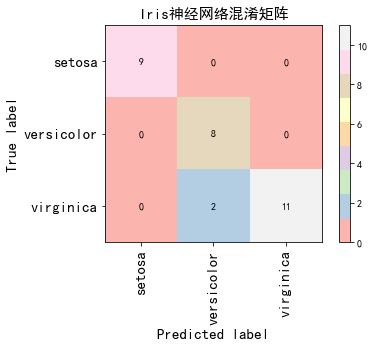

In [12]:
from sklearn.metrics import accuracy_score,recall_score,f1_score,precision_score,confusion_matrix
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
c_matrix_bp = confusion_matrix(y_test, y_predict_bp)
print("BP混淆矩阵：\n",c_matrix_bp)
plot_confusion_matrix(c_matrix_bp, ['setosa','versicolor','virginica'], "Iris神经网络混淆矩阵")
plt.show()

In [13]:
print(X_train)
print(y_train_dum)

[[6.  2.9 4.5 1.5]
 [6.  2.7 5.1 1.6]
 [5.1 3.4 1.5 0.2]
 [5.6 3.  4.1 1.3]
 [6.7 3.  5.2 2.3]
 [7.9 3.8 6.4 2. ]
 [5.  3.5 1.6 0.6]
 [4.4 3.2 1.3 0.2]
 [6.  3.4 4.5 1.6]
 [5.6 2.7 4.2 1.3]
 [4.7 3.2 1.3 0.2]
 [6.8 2.8 4.8 1.4]
 [7.  3.2 4.7 1.4]
 [5.  2.3 3.3 1. ]
 [5.8 2.6 4.  1.2]
 [6.1 2.8 4.7 1.2]
 [6.3 3.3 4.7 1.6]
 [6.9 3.2 5.7 2.3]
 [6.4 3.2 4.5 1.5]
 [5.1 3.3 1.7 0.5]
 [4.8 3.  1.4 0.1]
 [6.5 3.  5.8 2.2]
 [7.3 2.9 6.3 1.8]
 [5.2 2.7 3.9 1.4]
 [6.2 2.9 4.3 1.3]
 [4.5 2.3 1.3 0.3]
 [6.5 3.  5.2 2. ]
 [4.9 2.5 4.5 1.7]
 [5.5 2.6 4.4 1.2]
 [5.4 3.9 1.7 0.4]
 [7.7 3.8 6.7 2.2]
 [4.4 3.  1.3 0.2]
 [5.5 2.5 4.  1.3]
 [7.2 3.  5.8 1.6]
 [6.4 3.1 5.5 1.8]
 [5.4 3.4 1.7 0.2]
 [5.1 2.5 3.  1.1]
 [6.3 2.7 4.9 1.8]
 [4.9 3.  1.4 0.2]
 [6.1 2.6 5.6 1.4]
 [6.3 2.8 5.1 1.5]
 [6.2 3.4 5.4 2.3]
 [5.  3.3 1.4 0.2]
 [6.7 3.1 4.7 1.5]
 [5.4 3.9 1.3 0.4]
 [5.4 3.  4.5 1.5]
 [5.7 2.9 4.2 1.3]
 [5.2 3.5 1.5 0.2]
 [6.  2.2 5.  1.5]
 [5.  3.4 1.5 0.2]
 [5.5 2.4 3.7 1. ]
 [5.6 2.8 4.9 2. ]
 [5.5 2.3 4.